In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from network_setup import initialize_population, assign_kids_to_schools, form_households, build_network, initialize_infection, gillespie_SIR, analyze_susceptible_clusters, giant_component

# TO-DO 
Make heat maps insted of averages, so we see possible "bifurcation"

Make .py file with functions to declutter.

Give some random prob of adults infection other adults outside of house holds - critical behavioure? 

## Possibility of schools being connected
We now assign kids randmly to schools, before assigning to households, such that a household with 2 kids attending 2 different institutions might cause transmission between the schools

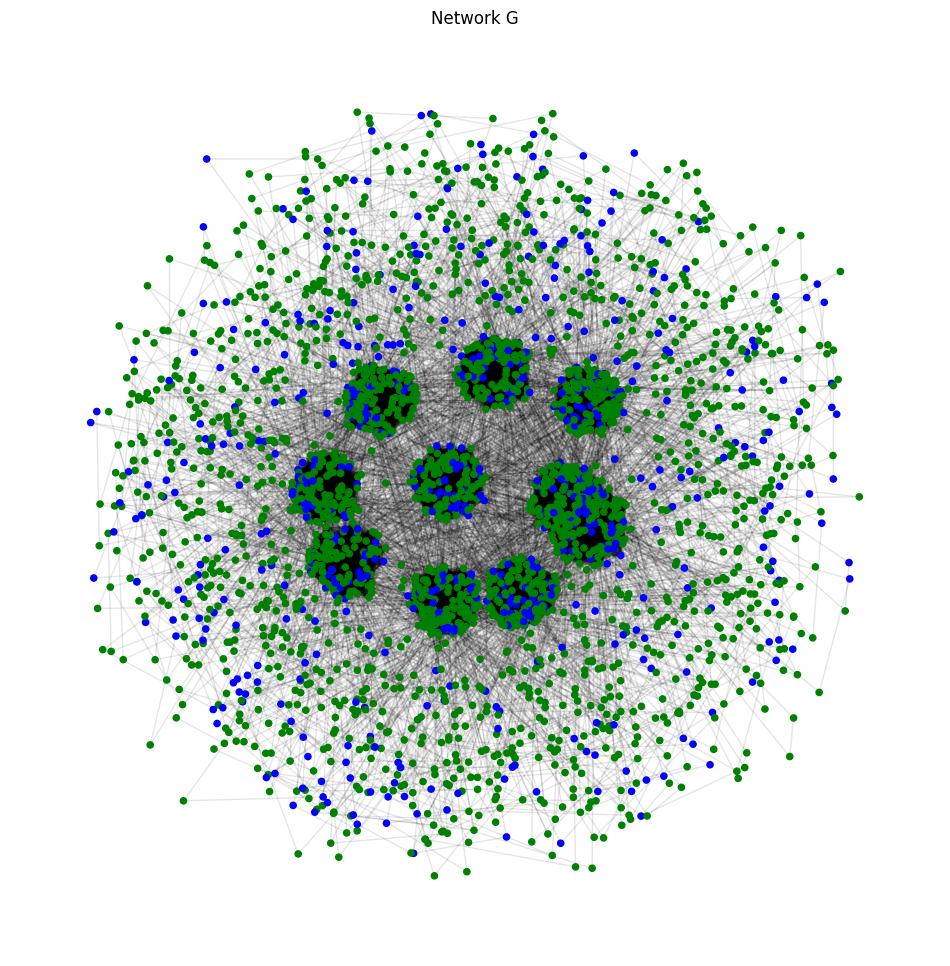

In [2]:
# Simulation parameters
Nh = 800           # Number of households
Ns = 10             # Number of schools
S_adult = 0.2       # Fraction of susceptible adults
S_kids = 0.2        # Fraction of susceptible kids
p_1 = 0.4           # Fraction of 1-kid households
beta = 1.6          # Infection rate
nu = beta/12           # Recovery rate
p_inh = .8


# Total number of adults and kids
num_adults = Nh * 2
num_1kid_houses = int(Nh * p_1)
num_2kid_houses = Nh - num_1kid_houses
num_kids = num_1kid_houses + num_2kid_houses * 2

adults, kids = initialize_population(S_adult, S_kids, num_adults, num_kids)
kids = assign_kids_to_schools(kids, Ns)
households = form_households(adults, kids, p_inh, num_1kid_houses, num_adults, num_kids)
G = build_network(adults, kids, households, Ns)


# Plotting the Entire Network again
plt.figure(figsize=(12, 12))

# Use a spring layout for positioning nodes
pos = nx.spring_layout(G, k=0.1, iterations=20)

# Get node colors based on status
node_colors = []
for node in G.nodes():
    status = G.nodes[node]['status']
    if status == 'S':
        node_colors.append('blue')
    elif status == 'I':
        node_colors.append('red')
    else:
        node_colors.append('green')

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('Network G')
plt.axis('off')
plt.show()


Households:800, kids:1280, total pop; 2880, kids pr. school:128.0, nr S: 576.0


 20%|██        | 1/5 [00:00<00:01,  2.70it/s]

p_inh: 0.00, Avg Outbreak Size: 4.6, Avg Fraction Infected: 0.0084, Avg Num Clusters: 290.0, Avg Cluster Size: 1.96, Avg Giant Component Size: 229.60


 40%|████      | 2/5 [00:01<00:02,  1.49it/s]

p_inh: 0.25, Avg Outbreak Size: 38.4, Avg Fraction Infected: 0.0654, Avg Num Clusters: 272.2, Avg Cluster Size: 2.14, Avg Giant Component Size: 204.00


 60%|██████    | 3/5 [00:06<00:05,  2.61s/it]

p_inh: 0.50, Avg Outbreak Size: 211.0, Avg Fraction Infected: 0.3676, Avg Num Clusters: 249.4, Avg Cluster Size: 2.32, Avg Giant Component Size: 267.60


 80%|████████  | 4/5 [00:09<00:02,  2.76s/it]

p_inh: 0.75, Avg Outbreak Size: 118.8, Avg Fraction Infected: 0.2111, Avg Num Clusters: 212.6, Avg Cluster Size: 2.65, Avg Giant Component Size: 294.40


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

p_inh: 1.00, Avg Outbreak Size: 263.2, Avg Fraction Infected: 0.4504, Avg Num Clusters: 205.4, Avg Cluster Size: 2.82, Avg Giant Component Size: 332.60


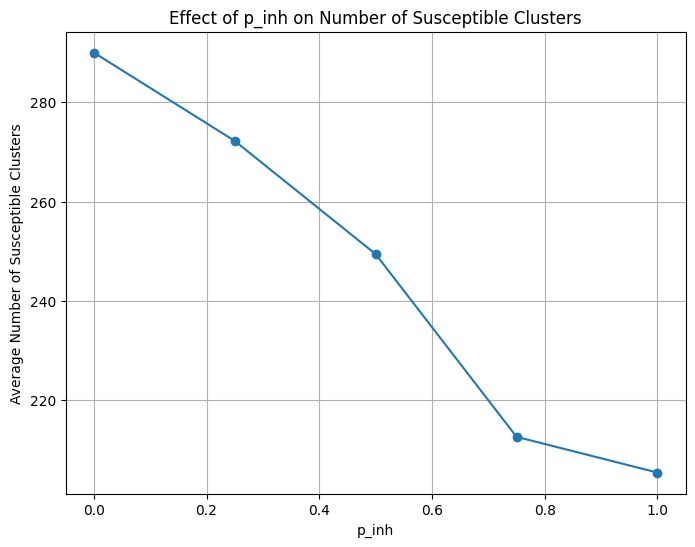

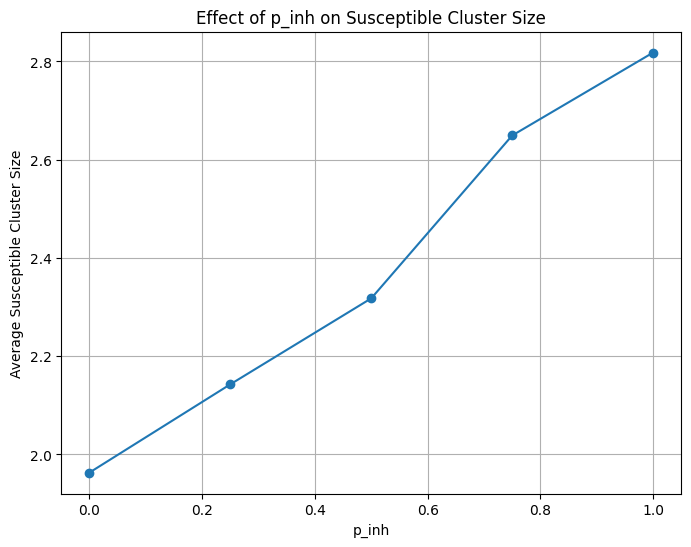

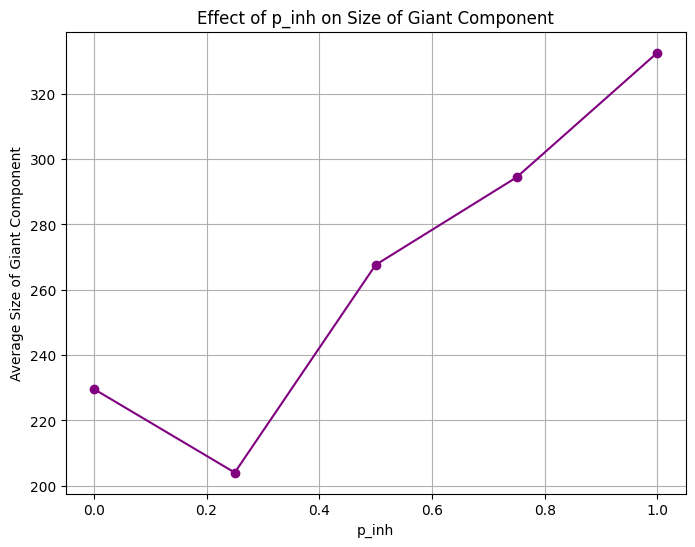

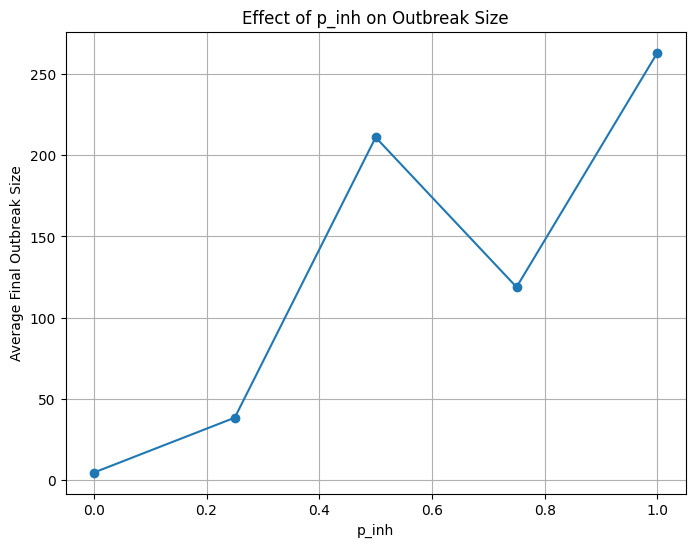

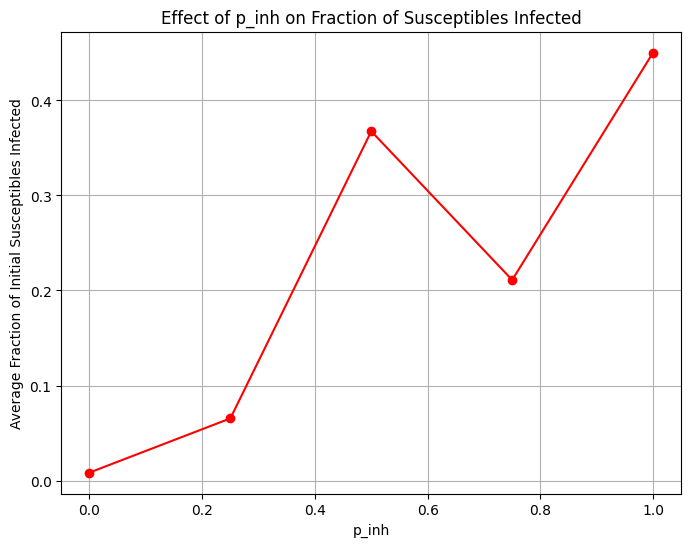

In [2]:
# Simulation parameters
Nh = 800           # Number of households
Ns = 10             # Number of schools
S_adult = 0.2       # Fraction of susceptible adults
S_kids = 0.2        # Fraction of susceptible kids
p_1 = 0.4           # Fraction of 1-kid households
beta = 1.6          # Infection rate
nu = beta/12           # Recovery rate
num_simulations = 5   # Number of simulations per p_inh


# Total number of adults and kids
num_adults = Nh * 2
num_1kid_houses = int(Nh * p_1)
num_2kid_houses = Nh - num_1kid_houses
num_kids = num_1kid_houses + num_2kid_houses * 2

print(f"Households:{Nh}, kids:{num_kids}, total pop; {num_kids + 2*Nh}, kids pr. school:{num_kids/Ns}, nr S: {S_adult*2*Nh + S_kids*num_kids}")

def run_simulation(p_inh):
    """Run the epidemic simulation for a given p_inh."""
    adults, kids = initialize_population(S_adult, S_kids, num_adults, num_kids)
    kids = assign_kids_to_schools(kids, Ns)
    households = form_households(adults, kids, p_inh, num_1kid_houses, num_adults, num_kids)
    G = build_network(adults, kids, households, Ns)
    
    # Analyze susceptible clusters before the epidemic
    num_clusters, cluster_sizes, giant_component_size = analyze_susceptible_clusters(G)
    
    # Initialize infection
    G = initialize_infection(G)
    if G is None:
        return None, None, None, None, 0, 0, num_clusters, cluster_sizes, giant_component_size  # No susceptible individuals to infect

    # Record the initial number of susceptibles
    initial_susceptible = sum(1 for n in G.nodes if G.nodes[n]['status'] == 'S' or G.nodes[n]['status'] == 'I')
    
    times, S_history, I_history, R_history = gillespie_SIR(G, beta, nu)
    total_recovered = sum(1 for n in G.nodes if G.nodes[n]['status'] == 'R')

    # Calculate the fraction of initially susceptible individuals who became infected
    final_size_fraction = (total_recovered - R_history[0])/ initial_susceptible if initial_susceptible > 0 else 0

    return times, S_history, I_history, R_history, total_recovered, final_size_fraction, num_clusters, cluster_sizes, giant_component_size

# Main simulation loop
p_inh_values = np.linspace(0, 1, 5)  # 5 values from 0 to 1
final_outbreak_sizes = []
final_outbreak_fractions = []
cluster_numbers = []
average_cluster_sizes = []
average_giant_component_sizes = []

for p_inh in tqdm(p_inh_values):
    outbreak_sizes = []
    outbreak_size_fractions = []
    num_clusters_list = []
    cluster_size_lists = []
    giant_component_sizes = []
    
    for _ in range(num_simulations):
        result = run_simulation(p_inh)
        if result[0] is None:
            continue  # Skip if no susceptible individuals
        times, S_history, I_history, R_history, total_recovered, final_size_fraction, num_clusters, cluster_sizes, giant_component_size = result
        outbreak_sizes.append(total_recovered-R_history[0])
        outbreak_size_fractions.append(final_size_fraction)
        num_clusters_list.append(num_clusters)
        cluster_size_lists.extend(cluster_sizes)  # Collect all cluster sizes
        giant_component_sizes.append(giant_component_size)
    
    avg_outbreak_size = np.mean(outbreak_sizes)
    avg_outbreak_fraction = np.mean(outbreak_size_fractions)
    avg_num_clusters = np.mean(num_clusters_list)
    avg_cluster_size = np.mean(cluster_size_lists) if cluster_size_lists else 0
    avg_giant_component_size = np.mean(giant_component_sizes)
    
    final_outbreak_sizes.append(avg_outbreak_size)
    final_outbreak_fractions.append(avg_outbreak_fraction)
    cluster_numbers.append(avg_num_clusters)
    average_cluster_sizes.append(avg_cluster_size)
    average_giant_component_sizes.append(avg_giant_component_size)
    
    print(f"p_inh: {p_inh:.2f}, Avg Outbreak Size: {avg_outbreak_size}, "
          f"Avg Fraction Infected: {avg_outbreak_fraction:.4f}, "
          f"Avg Num Clusters: {avg_num_clusters}, "
          f"Avg Cluster Size: {avg_cluster_size:.2f}, "
          f"Avg Giant Component Size: {avg_giant_component_size:.2f}")


# Plot average number of clusters vs. p_inh
plt.figure(figsize=(8,6))
plt.plot(p_inh_values, cluster_numbers, marker='o')
plt.xlabel('p_inh')
plt.ylabel('Average Number of Susceptible Clusters')
plt.title('Effect of p_inh on Number of Susceptible Clusters')
plt.grid(True)
plt.savefig("Plots/NR_clusters.pdf", dpi = 400)
plt.show()

# Plot average cluster size vs. p_inh
plt.figure(figsize=(8,6))
plt.plot(p_inh_values, average_cluster_sizes, marker='o')
plt.xlabel('p_inh')
plt.ylabel('Average Susceptible Cluster Size')
plt.title('Effect of p_inh on Susceptible Cluster Size')
plt.grid(True)
plt.savefig("Plots/size_clusters.pdf", dpi = 400)
plt.show()

# Plot average giant component size vs. p_inh
plt.figure(figsize=(8,6))
plt.plot(p_inh_values, average_giant_component_sizes, marker='o', color='purple')
plt.xlabel('p_inh')
plt.ylabel('Average Size of Giant Component')
plt.title('Effect of p_inh on Size of Giant Component')
plt.grid(True)
plt.savefig("Plots/giant_clusters.pdf", dpi = 400)
plt.show()

# Plot outbreak size vs. p_inh
plt.figure(figsize=(8, 6))
plt.plot(p_inh_values, final_outbreak_sizes, marker='o')
plt.xlabel('p_inh')
plt.ylabel('Average Final Outbreak Size')
plt.title('Effect of p_inh on Outbreak Size')
plt.grid(True)
plt.savefig("Plots/outbreak_size.pdf", dpi = 400)
plt.show()

# Plot outbreak fraction vs. p_inh
plt.figure(figsize=(8, 6))
plt.plot(p_inh_values, final_outbreak_fractions, marker='o', color='red')
plt.xlabel('p_inh')
plt.ylabel('Average Fraction of Initial Susceptibles Infected')
plt.title('Effect of p_inh on Fraction of Susceptibles Infected')
plt.grid(True)
plt.savefig("Plots/outbreak_frac.pdf", dpi = 400)
plt.show()


Households:200, kids:380, total pop; 780, kids pr. school:76.0, nr S: 156.0
S_kid: 0.00, p_inh: 0.00, Avg Fraction Infected: 0.0127, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.05, Avg Fraction Infected: 0.0178, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.11, Avg Fraction Infected: 0.0129, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.16, Avg Fraction Infected: 0.0121, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.21, Avg Fraction Infected: 0.0126, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.26, Avg Fraction Infected: 0.0128, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.32, Avg Fraction Infected: 0.0126, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.37, Avg Fraction Infected: 0.0128, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.42, Avg Fraction Infected: 0.0155, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.47, Avg Fraction Infected: 0.0118, Avg Giant Component Size: 2.00
S_kid: 0.00, p_inh: 0.53, Avg Fraction Infec

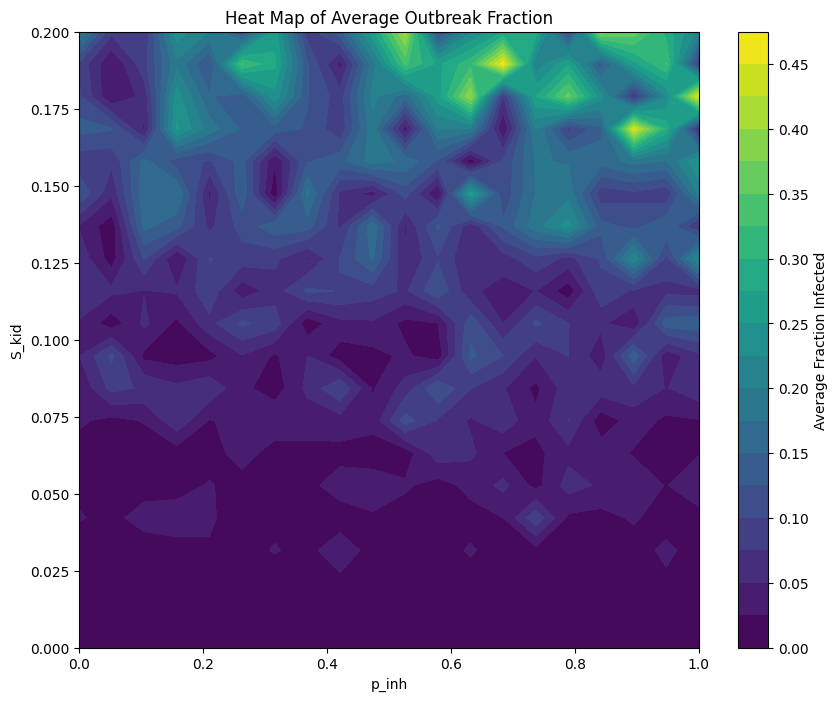

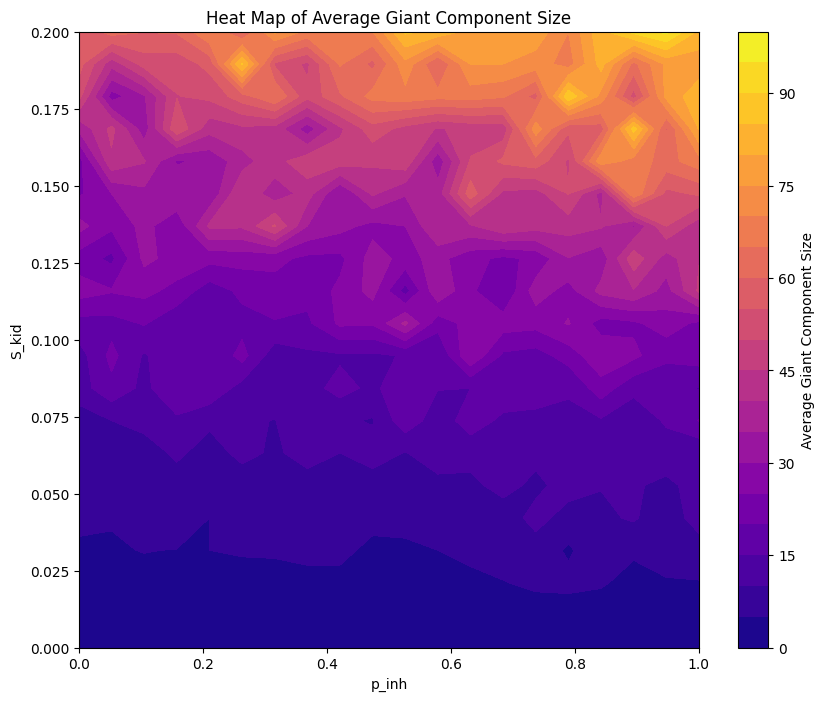

In [19]:
# Simulation parameters
Nh = 200           # Number of households
Ns = 5             # Number of schools
S_adult = 0.2        # Fraction of susceptible kids
p_1 = 0.1           # Fraction of 1-kid households
beta = 1.6          # Infection rate
nu = beta/12           # Recovery rate
num_simulations = 5   # Number of simulations per p_inh


# Total number of adults and kids
num_adults = Nh * 2
num_1kid_houses = int(Nh * p_1)
num_2kid_houses = Nh - num_1kid_houses
num_kids = num_1kid_houses + num_2kid_houses * 2

print(f"Households:{Nh}, kids:{num_kids}, total pop; {num_kids + 2*Nh}, kids pr. school:{num_kids/Ns}, nr S: {S_adult*2*Nh + S_kids*num_kids}")


# Parameter ranges
p_inh_values = np.linspace(0, 1, 20)        # 10 values from 0 to 1 for p_inh
S_kids_values = np.linspace(0, .2, 20)      # 10 values from 0 to 1 for S_adult

def run_simulation(p_inh, S_kids):
    """Run the epidemic simulation for a given p_inh and S_adult."""
    adults, kids = initialize_population(S_adult, S_kids, num_adults, num_kids)
    kids = assign_kids_to_schools(kids, Ns)
    households = form_households(adults, kids, p_inh, num_1kid_houses, num_adults, num_kids)
    G = build_network(adults, kids, households, Ns)
    
    # Analyze susceptible clusters before the epidemic
    giant_component_size = giant_component(G)
    
    # Initialize infection
    G = initialize_infection(G)
    if G is None:
        return None, 0, giant_component_size  # No susceptible individuals to infect

    # Record the initial number of susceptibles
    initial_susceptible = sum(1 for n in G.nodes if G.nodes[n]['status'] == 'S' or G.nodes[n]['status'] == 'I')
    
    times, S_history, I_history, R_history = gillespie_SIR(G, beta, nu)
    total_recovered = sum(1 for n in G.nodes if G.nodes[n]['status'] == 'R')

    # Calculate the fraction of initially susceptible individuals who became infected
    final_size_fraction = (total_recovered-R_history[0]) / initial_susceptible if initial_susceptible > 0 else 0

    return final_size_fraction, total_recovered, giant_component_size
    
# Initialize arrays to store results
avg_outbreak_fractions = np.zeros((len(S_kids_values), len(p_inh_values)))
avg_giant_component_sizes = np.zeros((len(S_kids_values), len(p_inh_values)))

# Main simulation loop
for i, S_kid in enumerate(S_kids_values):
    for j, p_inh in enumerate(p_inh_values):
        outbreak_size_fractions = []
        giant_component_sizes = []
        for _ in range(num_simulations):
            result = run_simulation(p_inh, S_kid)
            if result[0] is None:
                continue  # Skip if no susceptible individuals
            final_size_fraction, total_recovered, giant_component_size = result
            outbreak_size_fractions.append(final_size_fraction)
            giant_component_sizes.append(giant_component_size)
        if outbreak_size_fractions:
            avg_outbreak_fraction = np.mean(outbreak_size_fractions)
            avg_giant_component_size = np.mean(giant_component_sizes)
        else:
            avg_outbreak_fraction = 0
            avg_giant_component_size = 0
        avg_outbreak_fractions[i, j] = avg_outbreak_fraction
        avg_giant_component_sizes[i, j] = avg_giant_component_size
        print(f"S_kid: {S_kid:.2f}, p_inh: {p_inh:.2f}, "
              f"Avg Fraction Infected: {avg_outbreak_fraction:.4f}, "
              f"Avg Giant Component Size: {avg_giant_component_size:.2f}")

# Create heat maps
X, Y = np.meshgrid(p_inh_values, S_kids_values)

# Plot average outbreak fraction heat map
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, avg_outbreak_fractions, levels=20, cmap='viridis')
plt.colorbar(label='Average Fraction Infected')
plt.xlabel('p_inh')
plt.ylabel('S_kid')
plt.title('Heat Map of Average Outbreak Fraction')
plt.savefig("Plots/Outbreak_frac_heatmap.pdf", dpi = 400)
plt.show()

# Plot average giant component size heat map
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, avg_giant_component_sizes, levels=20, cmap='plasma')
plt.colorbar(label='Average Giant Component Size')
plt.xlabel('p_inh')
plt.ylabel('S_kid')
plt.title('Heat Map of Average Giant Component Size')
plt.savefig("Plots/Giant_comp_heatmap.pdf", dpi = 400)
plt.show()


Maybe do actual pop dynamics, there are N_h pairs, they all get 1 or 2 offspring by some probability. All of their offspring are by p_inh prob. unvaccinated if one of the parents are, then assign randomly to a school of which there are N_s.

## Family formation algo 

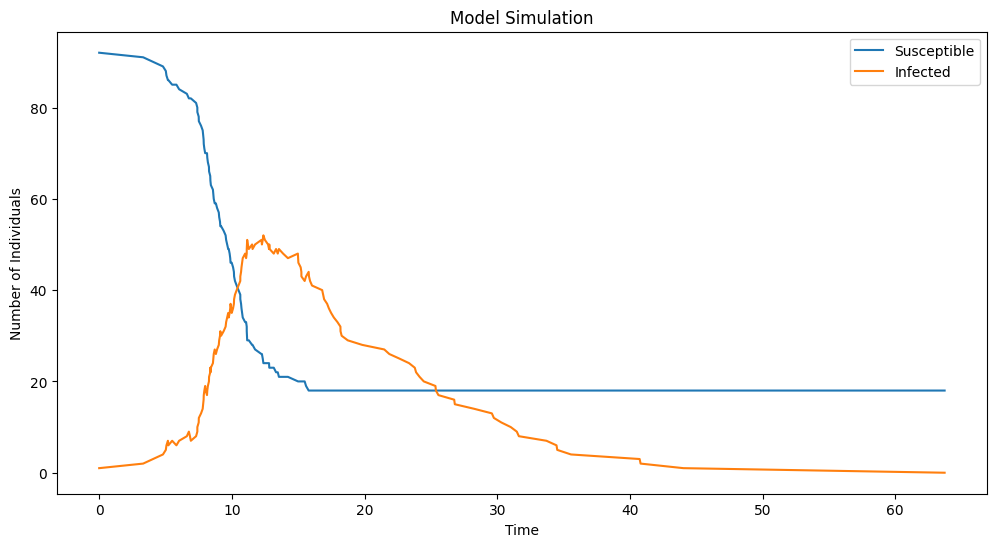

In [67]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Simulation parameters
N_h = 2500       # Number of households
N_s = 5         # Number of schools
S_adult = 0.01    # Probability an adult is unvaccinated
p_1 = 0.5        # Probability a household has 1 child
p_inh = 0.7      # Probability child is unvaccinated if one parent is unvaccinated

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Step 1: Generate Adults

num_adults = N_h * 2
# Adults' vaccination status: True for unvaccinated, False for vaccinated
adults_unvaccinated = np.random.rand(num_adults) < S_adult
# Reshape into households of two adults
adults_unvaccinated = adults_unvaccinated.reshape((N_h, 2))

# Step 2: Assign Number of Children per Household

num_1child_households = int(N_h * p_1)
num_2child_households = N_h - num_1child_households
# Array of number of children per household
num_children_per_household = np.array([1]*num_1child_households + [2]*num_2child_households)
# Shuffle to randomize households
np.random.shuffle(num_children_per_household)

# Step 3: Generate Children's Vaccination Status

total_children = num_children_per_household.sum()
# Household indices for each child
household_indices = np.repeat(np.arange(N_h), num_children_per_household)
# Determine if each household has at least one unvaccinated parent
household_has_unvaccinated_parent = np.any(adults_unvaccinated, axis=1)
# For each child, get whether their household has an unvaccinated parent
child_has_unvaccinated_parent = household_has_unvaccinated_parent[household_indices]
# Initialize children's vaccination status: False for vaccinated
children_unvaccinated = np.zeros(total_children, dtype=bool)
# Indices of children with at least one unvaccinated parent
indices_unvacc_parent = np.where(child_has_unvaccinated_parent)[0]
# Assign unvaccinated status with probability p_inh
children_unvaccinated[indices_unvacc_parent] = np.random.rand(len(indices_unvacc_parent)) < p_inh

# Step 4: Assign Kids to Schools Randomly

# Assign each child to a school (school IDs from 0 to N_s - 1)
children_schools = np.random.randint(0, N_s, size=total_children)

# Step 5: Build the Network

G = nx.Graph()

# Assign IDs to adults and children
adult_ids = ['adult_{}'.format(i) for i in range(num_adults)]
child_ids = ['child_{}'.format(i) for i in range(total_children)]

# Reshape adult IDs into households
adult_ids_array = np.array(adult_ids).reshape((N_h, 2))

# Add adults to the graph
for i in range(num_adults):
    node_id = adult_ids[i]
    vaccinated = not adults_unvaccinated.flat[i]  # Convert unvaccinated to vaccinated status
    status = 'S' if not vaccinated else 'R'
    G.add_node(node_id, status=status, type='adult')

# Add children to the graph
for i in range(total_children):
    node_id = child_ids[i]
    vaccinated = not children_unvaccinated[i]
    status = 'S' if not vaccinated else 'R'
    school = children_schools[i]
    G.add_node(node_id, status=status, type='kid', school=school)

# Add household edges

# Spouse edges
for household in adult_ids_array:
    G.add_edge(household[0], household[1], relation='spouse')

# Parent-child edges
# We will connect each child to both parents
for i in range(total_children):
    child_id = child_ids[i]
    household_index = household_indices[i]
    parent_ids = adult_ids_array[household_index]
    for parent_id in parent_ids:
        G.add_edge(child_id, parent_id, relation='parent')

# Sibling edges
# Group children by household indices

household_children = defaultdict(list)
for idx, household_idx in enumerate(household_indices):
    household_children[household_idx].append(child_ids[idx])

# Add sibling edges
for siblings in household_children.values():
    if len(siblings) > 1:
        for i in range(len(siblings)):
            for j in range(i+1, len(siblings)):
                G.add_edge(siblings[i], siblings[j], relation='sibling')

# Add school edges

# Group children by school
school_children = defaultdict(list)
for idx, school_idx in enumerate(children_schools):
    school_children[school_idx].append(child_ids[idx])

# Add edges between all children in the same school (forming a clique)
for classmates in school_children.values():
    if len(classmates) > 1:
        for i in range(len(classmates)):
            for j in range(i+1, len(classmates)):
                G.add_edge(classmates[i], classmates[j], relation='classmate')

# Step 6: (Optional) Visualize the Network (may be slow for large networks)

# Uncomment the following lines to visualize a subgraph
# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(G, k=0.5)
# node_colors = ['blue' if G.nodes[n]['status'] == 'S' else 'green' for n in G.nodes()]
# nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=50)
# plt.show()

# Step 7: Simulate the Epidemic Using Gillespie Algorithm

# Parameters for the epidemic model
beta = 0.3   # Transmission rate
nu = 0.1     # Recovery rate

def gillespie_SIR(G, beta, nu):
    time = 0
    times = [time]

    # Initialize lists
    S_nodes = [n for n, attr in G.nodes(data=True) if attr['status'] == 'S']
    I_nodes = []

    # If no susceptible individuals, exit
    if not S_nodes:
        print("No susceptible individuals to infect.")
        return times, [], [], []

    # Randomly infect one susceptible individual to start the epidemic
    initial_infected = np.random.choice(S_nodes)
    G.nodes[initial_infected]['status'] = 'I'
    I_nodes.append(initial_infected)
    S_nodes.remove(initial_infected)

    # Initialize SI_edges as set of tuples (infected_node, susceptible_node)
    SI_edges = set()
    for neighbor in G.neighbors(initial_infected):
        if G.nodes[neighbor]['status'] == 'S':
            SI_edges.add((initial_infected, neighbor))

    # Initialize history tracking
    S_history = [len(S_nodes)]
    I_history = [len(I_nodes)]
    R_history = [len(G.nodes) - len(S_nodes) - len(I_nodes)]

    while I_nodes:
        a_infection = beta * len(SI_edges)
        a_recovery = nu * len(I_nodes)
        a_total = a_infection + a_recovery

        if a_total == 0:
            break  # No more events can occur

        # Time to next event
        dt = np.random.exponential(1 / a_total)
        time += dt

        # Determine which event occurs
        if np.random.rand() < a_infection / a_total:
            # Infection event
            if SI_edges:
                # Randomly select an S-I edge
                u, v = random.choice(list(SI_edges))  # u is infected, v is susceptible
                # Infect node v
                G.nodes[v]['status'] = 'I'
                I_nodes.append(v)
                S_nodes.remove(v)
                # Update SI_edges
                # Remove any SI_edges where v is the susceptible node
                SI_edges = {edge for edge in SI_edges if edge[1] != v}
                # Add new SI_edges where v is now the infected node
                for neighbor in G.neighbors(v):
                    if G.nodes[neighbor]['status'] == 'S':
                        SI_edges.add((v, neighbor))
        else:
            # Recovery event
            u = random.choice(I_nodes)
            G.nodes[u]['status'] = 'R'
            I_nodes.remove(u)
            # Update SI_edges by removing edges where u is the infected node
            SI_edges = {edge for edge in SI_edges if edge[0] != u}

        # Record history
        S_history.append(len(S_nodes))
        I_history.append(len(I_nodes))
        R_history.append(len(G.nodes) - len(S_nodes) - len(I_nodes))
        times.append(time)

    return times, S_history, I_history, R_history


# Run the simulation
times, S_history, I_history, R_history = gillespie_SIR(G, beta, nu)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(times, S_history, label='Susceptible')
plt.plot(times, I_history, label='Infected')
#plt.plot(times, R_history, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.legend()
plt.title('Model Simulation')
plt.show()


S_adult: 0.11, p_inh: 0.00, Total Susceptibles: 90, Fraction Infected: 0.0111
S_adult: 0.11, p_inh: 0.00, Total Susceptibles: 94, Fraction Infected: 0.0106
S_adult: 0.11, p_inh: 0.00, Total Susceptibles: 89, Fraction Infected: 0.0112
S_adult: 0.11, p_inh: 0.00, Total Susceptibles: 89, Fraction Infected: 0.0112
S_adult: 0.11, p_inh: 0.00, Total Susceptibles: 96, Fraction Infected: 0.0104
S_adult: 0.11, p_inh: 0.11, Total Susceptibles: 117, Fraction Infected: 0.1368
S_adult: 0.11, p_inh: 0.11, Total Susceptibles: 93, Fraction Infected: 0.0108
S_adult: 0.11, p_inh: 0.11, Total Susceptibles: 98, Fraction Infected: 0.0204
S_adult: 0.11, p_inh: 0.11, Total Susceptibles: 106, Fraction Infected: 0.0094
S_adult: 0.11, p_inh: 0.11, Total Susceptibles: 93, Fraction Infected: 0.2258
S_adult: 0.11, p_inh: 0.22, Total Susceptibles: 125, Fraction Infected: 0.0080
S_adult: 0.11, p_inh: 0.22, Total Susceptibles: 120, Fraction Infected: 0.0083
S_adult: 0.11, p_inh: 0.22, Total Susceptibles: 104, Fractio

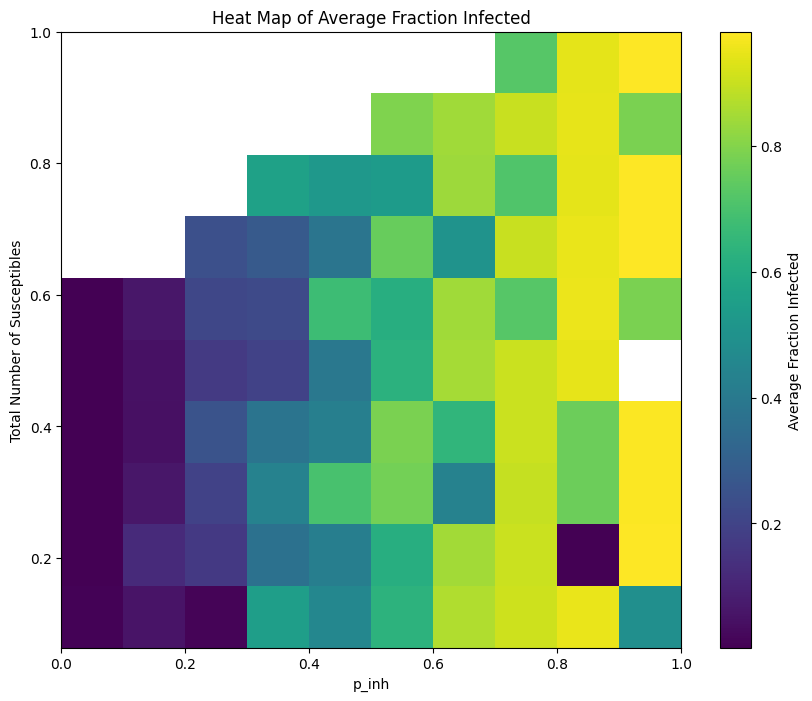

In [63]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from scipy.stats import binned_statistic_2d


# Simulation parameters
N_h = 400       # Number of households
N_s = 2         # Number of schools
p_1 = 0.5       # Probability a household has 1 child
beta = 0.9      # Transmission rate
nu = 0.1        # Recovery rate
num_simulations = 5  # Number of simulations per parameter combination

def build_network(N_h, N_s, p_1, p_inh, S_adult):
    """
    Build the network based on the given parameters.
    """
    num_adults = N_h * 2
    # Adults' vaccination status: True for unvaccinated, False for vaccinated
    adults_unvaccinated = np.random.rand(num_adults) < S_adult
    # Reshape into households of two adults
    adults_unvaccinated = adults_unvaccinated.reshape((N_h, 2))

    # Assign number of children per household
    num_1child_households = int(N_h * p_1)
    num_2child_households = N_h - num_1child_households
    num_children_per_household = np.array([1]*num_1child_households + [2]*num_2child_households)
    np.random.shuffle(num_children_per_household)

    # Generate children's vaccination status
    total_children = num_children_per_household.sum()
    household_indices = np.repeat(np.arange(N_h), num_children_per_household)
    household_has_unvaccinated_parent = np.any(adults_unvaccinated, axis=1)
    child_has_unvaccinated_parent = household_has_unvaccinated_parent[household_indices]
    children_unvaccinated = np.zeros(total_children, dtype=bool)
    indices_unvacc_parent = np.where(child_has_unvaccinated_parent)[0]
    children_unvaccinated[indices_unvacc_parent] = np.random.rand(len(indices_unvacc_parent)) < p_inh

    # Assign kids to schools randomly
    children_schools = np.random.randint(0, N_s, size=total_children)

    # Build the network
    G = nx.Graph()

    # Assign IDs to adults and children
    adult_ids = ['adult_{}'.format(i) for i in range(num_adults)]
    child_ids = ['child_{}'.format(i) for i in range(total_children)]

    # Reshape adult IDs into households
    adult_ids_array = np.array(adult_ids).reshape((N_h, 2))

    # Add adults to the graph
    for i in range(num_adults):
        node_id = adult_ids[i]
        vaccinated = not adults_unvaccinated.flat[i]  # Convert unvaccinated to vaccinated status
        status = 'S' if not vaccinated else 'R'
        G.add_node(node_id, status=status, type='adult')

    # Add children to the graph
    for i in range(total_children):
        node_id = child_ids[i]
        vaccinated = not children_unvaccinated[i]
        status = 'S' if not vaccinated else 'R'
        school = children_schools[i]
        G.add_node(node_id, status=status, type='kid', school=school)

    # Add household edges
    # Spouse edges
    for household in adult_ids_array:
        G.add_edge(household[0], household[1], relation='spouse')

    # Parent-child edges
    for i in range(total_children):
        child_id = child_ids[i]
        household_index = household_indices[i]
        parent_ids = adult_ids_array[household_index]
        for parent_id in parent_ids:
            G.add_edge(child_id, parent_id, relation='parent')

    # Sibling edges
    household_children = defaultdict(list)
    for idx, household_idx in enumerate(household_indices):
        household_children[household_idx].append(child_ids[idx])

    for siblings in household_children.values():
        if len(siblings) > 1:
            for i in range(len(siblings)):
                for j in range(i+1, len(siblings)):
                    G.add_edge(siblings[i], siblings[j], relation='sibling')

    # Add school edges
    school_children = defaultdict(list)
    for idx, school_idx in enumerate(children_schools):
        school_children[school_idx].append(child_ids[idx])

    for classmates in school_children.values():
        if len(classmates) > 1:
            for i in range(len(classmates)):
                for j in range(i+1, len(classmates)):
                    G.add_edge(classmates[i], classmates[j], relation='classmate')

    return G

def gillespie_SIR(G_original, beta, nu):
    """
    Run the Gillespie SIR simulation on the network G.
    """
    G = G_original.copy()  # Make a copy to avoid modifying the original network

    time = 0
    times = [time]

    # Initialize lists
    S_nodes = [n for n, attr in G.nodes(data=True) if attr['status'] == 'S']
    I_nodes = []

    # If no susceptible individuals, exit
    if not S_nodes:
        return times, [], [], []

    # Randomly infect one susceptible individual to start the epidemic
    initial_infected = random.choice(S_nodes)
    G.nodes[initial_infected]['status'] = 'I'
    I_nodes.append(initial_infected)
    S_nodes.remove(initial_infected)

    # Initialize SI_edges as set of tuples (infected_node, susceptible_node)
    SI_edges = set()
    for neighbor in G.neighbors(initial_infected):
        if G.nodes[neighbor]['status'] == 'S':
            SI_edges.add((initial_infected, neighbor))

    # Initialize history tracking
    S_history = [len(S_nodes)]
    I_history = [len(I_nodes)]
    R_history = [len(G.nodes) - len(S_nodes) - len(I_nodes)]

    while I_nodes:
        a_infection = beta * len(SI_edges)
        a_recovery = nu * len(I_nodes)
        a_total = a_infection + a_recovery

        if a_total == 0:
            break  # No more events can occur

        # Time to next event
        dt = np.random.exponential(1 / a_total)
        time += dt

        # Determine which event occurs
        if np.random.rand() < a_infection / a_total:
            # Infection event
            if SI_edges:
                # Randomly select an S-I edge
                u, v = random.choice(list(SI_edges))  # u is infected, v is susceptible
                # Infect node v
                if G.nodes[v]['status'] == 'S':
                    G.nodes[v]['status'] = 'I'
                    I_nodes.append(v)
                    S_nodes.remove(v)
                    # Update SI_edges
                    # Remove any SI_edges where v is the susceptible node
                    SI_edges = {edge for edge in SI_edges if edge[1] != v}
                    # Add new SI_edges where v is now the infected node
                    for neighbor in G.neighbors(v):
                        if G.nodes[neighbor]['status'] == 'S':
                            SI_edges.add((v, neighbor))
        else:
            # Recovery event
            u = random.choice(I_nodes)
            G.nodes[u]['status'] = 'R'
            I_nodes.remove(u)
            # Update SI_edges by removing edges where u is the infected node
            SI_edges = {edge for edge in SI_edges if edge[0] != u}

        # Record history
        S_history.append(len(S_nodes))
        I_history.append(len(I_nodes))
        R_history.append(len(G.nodes) - len(S_nodes) - len(I_nodes))
        times.append(time)

    return times, S_history, I_history, R_history

# Parameter grids
p_inh_values = np.linspace(0, 1, 10)
S_adult_values = np.linspace(0, 1, 10)[1:]

# Initialize array to hold average outbreak sizes
avg_outbreak_sizes = np.zeros((len(S_adult_values), len(p_inh_values)))

# Initialize lists to hold data points
p_inh_list = []
total_susceptibles_list = []
fraction_infected_list = []

# Main simulation loop
for S_adult in S_adult_values:
    for p_inh in p_inh_values:
        for sim in range(num_simulations):
            # Build the network
            G = build_network(N_h, N_s, p_1, p_inh, S_adult)
            # Compute the total number of susceptible individuals in the network
            total_susceptible = len([n for n, attr in G.nodes(data=True) if attr['status'] == 'S'])
            # Run the simulation
            times, S_history, I_history, R_history = gillespie_SIR(G, beta, nu)
            # Compute the initial number of susceptible individuals
            initial_susceptible = len([n for n, attr in G.nodes(data=True) if attr['status'] == 'S' or attr['status'] == 'I'])
            # Compute the total number of recovered individuals at the end
            total_recovered = R_history[-1] if R_history else 0
            # Compute the fraction of initially susceptible individuals who became infected
            if initial_susceptible > 0:
                fraction_infected = (total_recovered-R_history[0])/initial_susceptible
            else:
                fraction_infected = 0
            # Collect data points
            p_inh_list.append(p_inh)
            total_susceptibles_list.append(total_susceptible/np.shape(G)[0])
            fraction_infected_list.append(fraction_infected)
            print(f"S_adult: {S_adult:.2f}, p_inh: {p_inh:.2f}, Total Susceptibles: {total_susceptible}, Fraction Infected: {fraction_infected:.4f}")

# Convert lists to numpy arrays
p_inh_array = np.array(p_inh_list)
total_susceptibles_array = np.array(total_susceptibles_list)
fraction_infected_array = np.array(fraction_infected_list)

# Define the number of bins
num_bins_p_inh = len(p_inh_values)
num_bins_susceptibles = 10  # You can adjust this number

# Create bins for p_inh and total_susceptibles
p_inh_bins = np.linspace(min(p_inh_values), max(p_inh_values), num_bins_p_inh + 1)
susceptibles_bins = np.linspace(total_susceptibles_array.min(), total_susceptibles_array.max(), num_bins_susceptibles + 1)

# Use binned_statistic_2d to compute the average fraction infected in each bin
statistic, x_edge, y_edge, binnumber = binned_statistic_2d(
    p_inh_array,
    total_susceptibles_array,
    fraction_infected_array,
    statistic='mean',
    bins=[p_inh_bins, susceptibles_bins]
)

# Plot the heat map
X, Y = np.meshgrid(p_inh_bins, susceptibles_bins)
plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, statistic.T, shading='auto', cmap='viridis')
plt.colorbar(label='Average Fraction Infected')
plt.xlabel('p_inh')
plt.ylabel('Total Number of Susceptibles')
plt.title('Heat Map of Average Fraction Infected')
plt.show()



The numnber of susceptibles in whole system on y-axis.

In [61]:
np.shape(G)[0]

1400